In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential # Подлючаем класс создания модели Sequential
from tensorflow.keras.layers import Dense# Подключаем класс Dense - полносвязный слой
from tensorflow.keras.optimizers import Adam # Подключаем оптимизатор Adam

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [59]:
df = pd.read_csv("D:\Рабочий стол\Мэг_питон\Нейронные сети\База_данных_нейро\pima-indians-diabetes.csv", header=None)
df.columns = ['pregnancies', 'glucose', 'blood_pressure', 'skin_fold', 'insulin', 'bmi', 'pedigree', 'age', 'diabetes_class']
df.head()

,pregnancies,glucose,blood_pressure,skin_fold,insulin,bmi,pedigree,age,diabetes_class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [60]:
df.shape

(768, 9)

In [61]:
df.info() # пропусков нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pregnancies     768 non-null    int64  
 1   glucose         768 non-null    int64  
 2   blood_pressure  768 non-null    int64  
 3   skin_fold       768 non-null    int64  
 4   insulin         768 non-null    int64  
 5   bmi             768 non-null    float64
 6   pedigree        768 non-null    float64
 7   age             768 non-null    int64  
 8   diabetes_class  768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [62]:
df['diabetes_class'].value_counts() # наблюдается дисбаланс классов

diabetes_class
0    500
1    268
Name: count, dtype: int64

#### Базовое EDA

In [63]:
df.describe()

,pregnancies,glucose,blood_pressure,skin_fold,insulin,bmi,pedigree,age,diabetes_class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


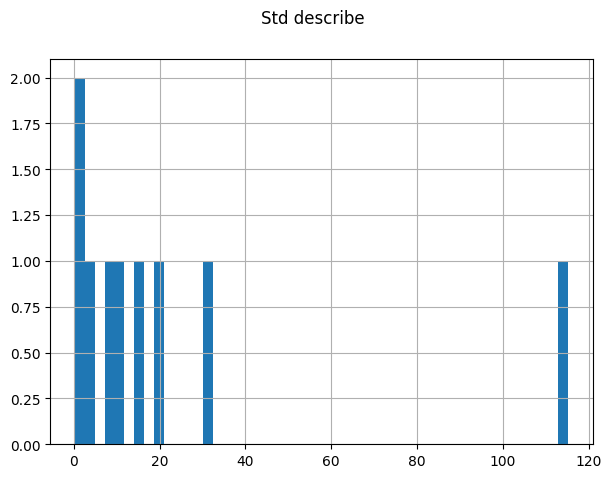

In [64]:
df.describe().loc['std', :].hist(bins=50, figsize=(7,5)) 
plt.suptitle('Std describe')
plt.show()
# необходимо масштабирвать

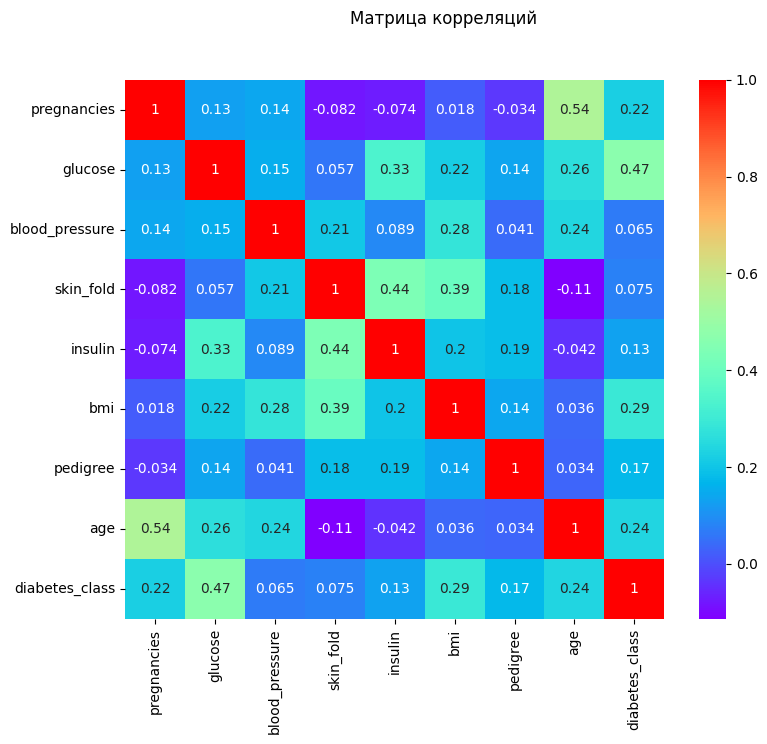

In [65]:
tmp = df.select_dtypes(exclude='object').corr()
plt.figure(figsize=(9,7))
sns.heatmap(tmp, annot=True, cmap='rainbow')
plt.imshow(tmp)
plt.suptitle('Матрица корреляций')
plt.show()

Text(0.5, 1.0, 'Параметры распределения')

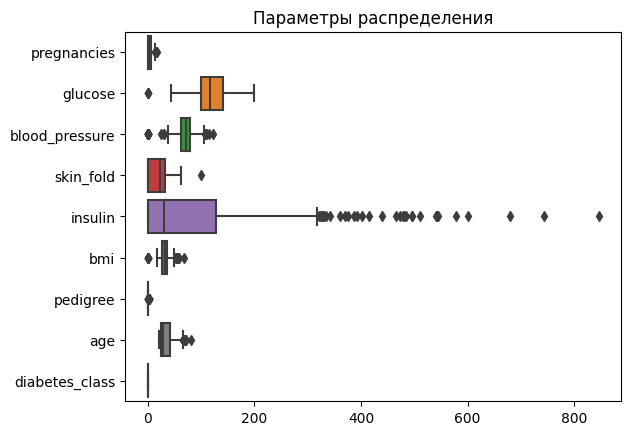

In [66]:
sns.boxplot(df, orient= 'h').set_title('Параметры распределения')

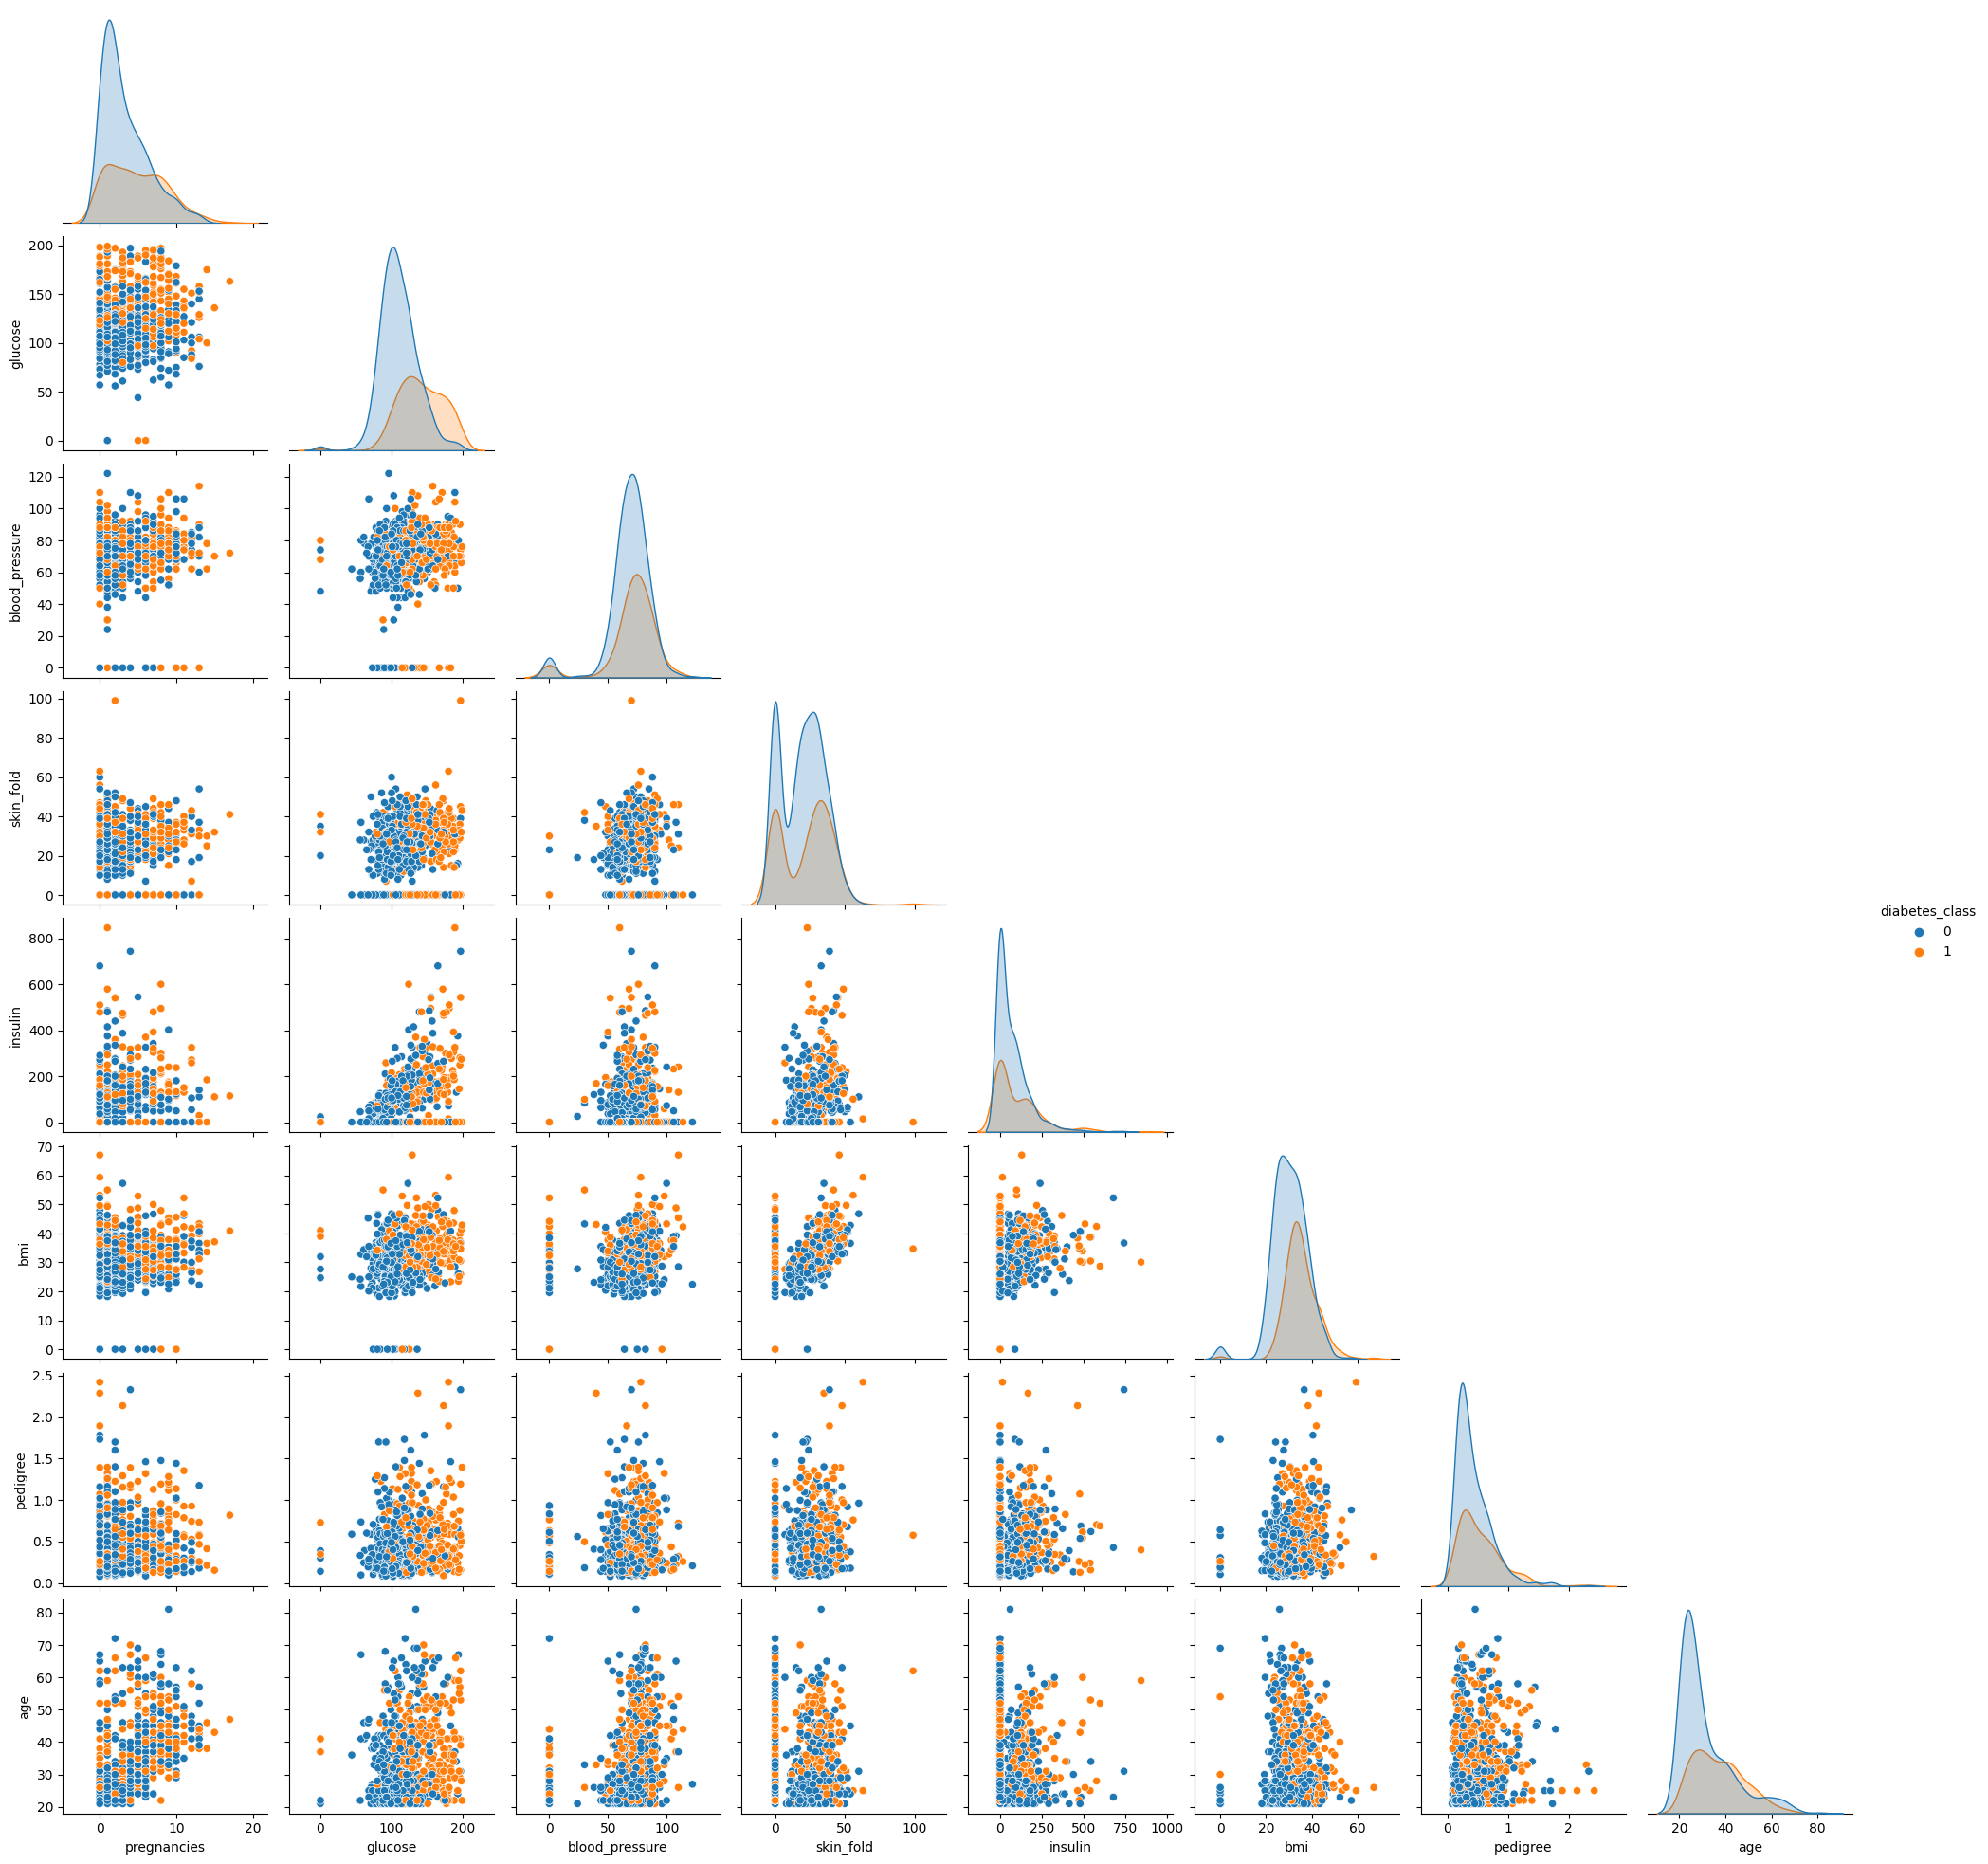

In [67]:
sns.pairplot(df, corner=True, hue='diabetes_class')

Сильно коррелирующих признаков нет, однако есть зависимость между возрастом и количеством беременностей (0.54), диабетом и уровнем глюкозы натощак (0.47), инсулином и толщиной кожной складки трицепса (0.44). Чем выше уровень глюкозы(от 130), тем больше вероятность заболевания; большинство людей с индексом массы тела около 40 и выше - имеют диабет. В данных есть выбросы.

#### Создаем тренировочную и валидационную выборки

In [68]:
x = df.drop(['diabetes_class'], axis=1)
y = df['diabetes_class']

x = x.astype('float64') # преобразовываем в тип float (необходим сетям Керас для обучения)
x_norm = StandardScaler().fit_transform(x) # Приводим признаки к единому масштабу

In [69]:
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, 
test_size = 0.25, random_state = 42)

In [70]:
print(x_train.shape)
print(x_test.shape)

(576, 8)
(192, 8)


#### Создание функции

In [71]:
def architecture_assembly():
    model = Sequential() # Создаём полносвязную сеть
    # класс Sequential указывает, что задаём последовательно связанные между собой слои

    model.add(Dense(60, activation="relu", input_dim = 8)) # Добавляем полносвязный (входной скрытый) слой на 60 нейронов с relu-активацией, указываем входной размер, соответствующий размеру входных данных
    model.add(Dense(30, activation="relu")) # Добавляем полносвязный (скрытый) слой на 30 нейронов с relu-активацией 
    model.add(Dense(1, activation="sigmoid")) # Добавляем полносвязный (выходной) слой на 1 нейрон с   sigmoid-активацией - сигмоида подходит для бинарной классификации

    # Компилируем модель
    model.compile(
        loss = 'binary_crossentropy', # Для задач бинарной классификации подходит функция двоичной перекрестной энтропии - показывает степень отличия прогнозного вероятностного распределения (полученное на выходе функции softmax) от истинного (целевая переменная)
        optimizer = 'adam', # эффективный алгоритм оптимизации (рез. лучше метода стохастического градиентного спуска), для снижения потери или ошибок и подобора правильныго веса в процессе back propagation
        metrics = ['accuracy'] # метрика классификации (отношение числа правильных ответов к размеру тестовой выборки)
        )

    return model

#### Обучение модели

In [87]:
model = architecture_assembly()
history = model.fit(x_train, y_train, batch_size=32, epochs=5, 
validation_data=(x_test, y_test))

Epoch 1/5
18/18 [==============================] - 1s 11ms/step - loss: 0.6463 - accuracy: 0.6823 - val_loss: 0.6012 - val_accuracy: 0.6823
Epoch 2/5
18/18 [==============================] - 0s 3ms/step - loss: 0.5511 - accuracy: 0.7535 - val_loss: 0.5424 - val_accuracy: 0.7552
Epoch 3/5
18/18 [==============================] - 0s 3ms/step - loss: 0.4967 - accuracy: 0.7674 - val_loss: 0.5129 - val_accuracy: 0.7448
Epoch 4/5
18/18 [==============================] - 0s 3ms/step - loss: 0.4666 - accuracy: 0.7795 - val_loss: 0.5037 - val_accuracy: 0.7708
Epoch 5/5
18/18 [==============================] - 0s 4ms/step - loss: 0.4508 - accuracy: 0.7847 - val_loss: 0.5055 - val_accuracy: 0.7708


In [109]:
val_loss, val_acc = model.evaluate(x_test, y_test)
print('Validation accuracy: %.3f'% val_acc)

6/6 [==============================] - 0s 2ms/step - loss: 0.5055 - accuracy: 0.7708
Validation accuracy: 0.771


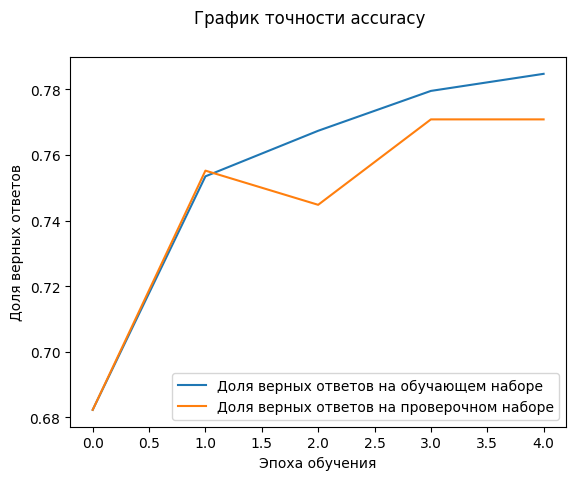

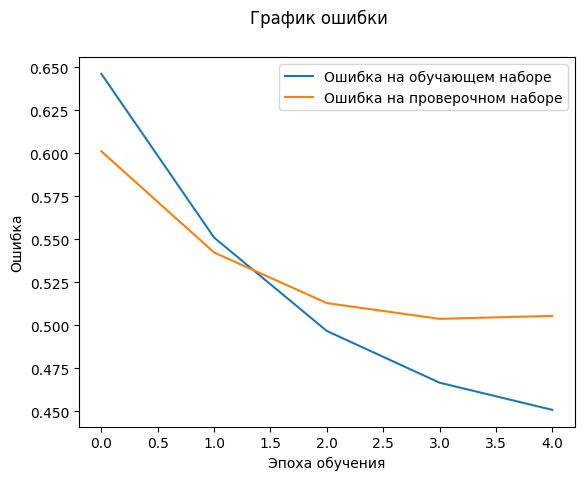

In [89]:
# Выводим график точности на обучающей выборке
# label - имя графика в легенде
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')

# Выводим график точности на проверочной выборке
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')

plt.suptitle('График точности accuracy')
# Подпись осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')

# Выводим легенду
plt.legend()
plt.show()


# Выводим графики ошибки
plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.suptitle('График ошибки')
plt.legend()
plt.show()

6/6 [==============================] - 0s 2ms/step


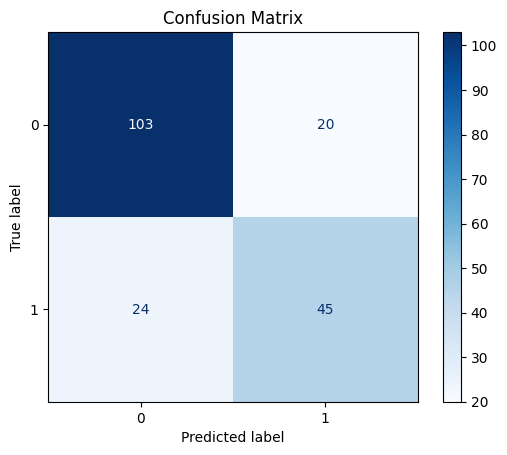

In [104]:
pred_test = model.predict(x_test)
pred_class = (pred_test>0.5).astype(int)

# визуализация матрицы ошибок
cm = ConfusionMatrixDisplay(confusion_matrix(y_test, pred_class), 
                       display_labels=['0', '1'])
cm.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

#### Pro:

Установка библиотеки scikera, импорт модуля KerasClassifie

In [ ]:
# !pip install scikeras[tensorflow]

In [124]:
from scikeras.wrappers import KerasClassifier

In [196]:
# создаем функцию, которая возвращает модель Keras
def make_model(activation):
    model = Sequential([
          Dense(60, activation=activation,  kernel_initializer="glorot_uniform", 
          input_dim = 8, name="layer1"),
          Dense(30, activation=activation, kernel_initializer="glorot_uniform", 
          name="layer2"),
          Dense(1, activation="sigmoid", name="layer3"), ])
    
    model.compile(
          loss = 'binary_crossentropy', optimizer = 'adam', 
          metrics = ['accuracy'])
    return model

Обертка модели

In [198]:
model_keras = KerasClassifier(model=make_model, activation = "relu")

In [199]:
model = KerasClassifier(model=make_model, batch_size=32, optimizer="adam", 
metrics=["accuracy"],loss="binary_crossentropy",validation_split=0.2, epochs=1)

In [200]:
params = {
    "batch_size":[32, 64, 96],
    "epochs":[5,10,15,20],
    "optimizer":["adam","sgd"],
    "activation":["relu", "sigmoid"]
}

In [131]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [202]:
grid_search = GridSearchCV(estimator = model_keras, param_grid=params, cv=5) # n_jobs=-1
grid_search.fit(x_train, y_train)

Epoch 1/5
15/15 [==============================] - 1s 2ms/step - loss: 0.6975 - accuracy: 0.5174
Epoch 2/5
15/15 [==============================] - 0s 3ms/step - loss: 0.6166 - accuracy: 0.7304
Epoch 3/5
15/15 [==============================] - 0s 2ms/step - loss: 0.5560 - accuracy: 0.7674
Epoch 4/5
15/15 [==============================] - 0s 3ms/step - loss: 0.5129 - accuracy: 0.7739
Epoch 5/5
4/4 [==============================] - 0s 2ms/step
Epoch 1/5
15/15 [==============================] - 1s 2ms/step - loss: 0.7247 - accuracy: 0.4382
Epoch 2/5
15/15 [==============================] - 0s 2ms/step - loss: 0.6510 - accuracy: 0.6963
Epoch 3/5
15/15 [==============================] - 0s 2ms/step - loss: 0.6037 - accuracy: 0.7614
Epoch 4/5
15/15 [==============================] - 0s 2ms/step - loss: 0.5605 - accuracy: 0.7592
Epoch 5/5
4/4 [==============================] - 0s 1ms/step
Epoch 1/5
15/15 [==============================] - 1s 2ms/step - loss: 0.6871 - accuracy: 0.5358
Epoch

GridSearchCV(cv=5,
             estimator=KerasClassifier(activation='relu', model=<function make_model at 0x0000026E85F3E700>),
             param_grid={'activation': ['relu', 'sigmoid'],
                         'batch_size': [32, 64, 96], 'epochs': [5, 10, 15, 20],
                         'optimizer': ['adam', 'sgd']})

In [205]:
grid_search.best_params_

{'activation': 'relu', 'batch_size': 32, 'epochs': 20, 'optimizer': 'sgd'}

In [212]:
best_model = grid_search.best_estimator_

In [227]:
predictions_val = grid_search.predict(x_test)
print("Accuracy test: %.3f"% accuracy_score(y_test, predictions_val))

6/6 [==============================] - 0s 2ms/step
Accuracy test: 0.734


6/6 [==============================] - 0s 2ms/step


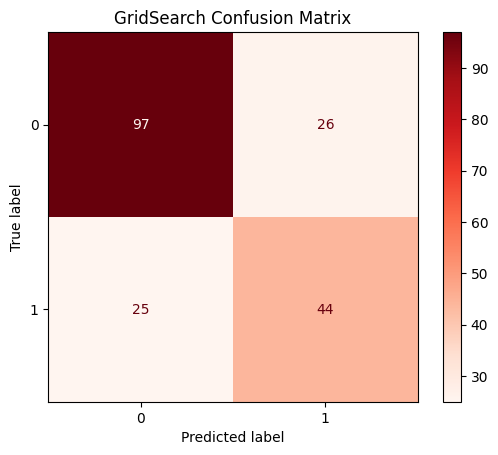

In [228]:
pred_test_gr = grid_search.predict_proba(x_test)
pred_class_gr = (pred_test>0.5).astype(int)

# визуализация матрицы ошибок
cm = ConfusionMatrixDisplay(confusion_matrix(y_test, pred_class), 
                       display_labels=['0', '1'])
cm.plot(cmap=plt.cm.Reds)
plt.title('GridSearch Confusion Matrix')
plt.show()

В данном запуске с помощью GridSearch получена наилучшая модель (Accuracy test = 0.734) с параметрами 'activation': 'relu', 'batch_size': 32, 'epochs': 20, 'optimizer': 'sgd', количество слоев и нейронов как и в предыдущей модели: первый (входной) слой - 60 нейронов, второй скрытый слой - 30, выходной - 1. Однако полученная метрика качества чуть ниже, что может менятся при перезапуске (чаще колебания +- 0.03).